**Кейс №1 - Приложение знакомств**

Вы работаете аналитиком в приложении для онлайн-знакомств. Механика приложения следующая: пользователи видят в приложении анкеты друг друга и могут ставить друг другу лайки или дизлайки. Если пользователи поставили друг другу лайк – это называется мэтч, и у пользователей появляется возможность познакомиться.

Команда приложения разработала новый алгоритм для поиска наиболее подходящих анкет. Для проверки работы алгоритма был проведен АБ-тест. Все пользователи были разделены на две группы. Пользователи в группе с номером 0 пользовались приложением со старым алгоритмом. Все пользователи в группе 1 пользовались приложением с новым алгоритмом для поиска анкет.

Ваша задача – оценить, правда ли, что новый алгоритм улучшил качество сервиса. Для этого нужно выбрать метрики, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.

В данных находится выгрузка логов взаимодействия пользователей друг с другом. Для каждой пары пользователей указано, из какой они группы АБ-теста и случился ли у них мэтч.

Результат вашей работы – аналитическое заключение с ответом на вопрос, стоит ли включать новую систему поиска анкет на всех пользователей.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import scipy

In [2]:
df = pd.read_csv('dating_data.csv')

In [3]:
df

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1
...,...,...,...,...
14509,476,631,0,0
14510,455,770,1,0
14511,260,6,1,1
14512,885,812,1,1


По данным видно, что переменная is_match - категориальная. Поэтому для оценки этой метрики понадобится таблица сопряженности, которая в свою очередь будет использоваться для расчета критерия хи-квадрат, чтобы оценить есть ли разница и статзначима ли она в тестовой и контрольной группах.

In [4]:
df_crosstab = pd.crosstab(df.group, df.is_match)
df_crosstab

is_match,0,1
group,,
0,3858,934
1,5813,3909


In [5]:
stats.chi2_contingency(df_crosstab)

(618.6889141576198,
 1.4418299163662586e-136,
 1,
 array([[3193.01584677, 1598.98415323],
        [6477.98415323, 3244.01584677]]))

Критерий хи-квадрат показал довольно маленькое число p-value, которое показывает что изменения есть и они значимые. Для более понятно интерпретации того какие изменения у нас случились с внедрением нового алгоритма, посчитаю конверсию в мэтч. Так как метрика is_match представлена нулями и единицами, конверсия достаточно легко считается через среднее значение этого столбца.

In [6]:
df_score = df.groupby('group', as_index=False).agg({'is_match': 'mean'})
df_score

,group,is_match
0,0,0.194908
1,1,0.402078


Фактически мы видим, что пары стали мэтчиться в два раза чаще, а критерий хи-квадрат показал, что эти различия не случайны и статистически значимы.

В качестве второй метрики для оценки эффективности АБ-теста я выбрал количество мэтчей на каждого пользователя. Соберу всех пользователей из контрольной и тестовой группы с отдельный датафрейм и посчитаю число мэтчей для каждого из них.

In [7]:
df_unique_1_group_0 = df[df.group == 0].user_id_1.value_counts().to_frame()
df_unique_2_group_0 = df[df.group == 0].user_id_2.value_counts().to_frame().rename(columns={'user_id_2': 'user_id_1'})
df_matches_group_0 = pd.concat([df_unique_1_group_0, df_unique_2_group_0], ignore_index=True)
df_matches_group_0

,user_id_1
0,20
1,18
2,18
3,17
4,17
...,...
997,4
998,4
999,4
1000,3


In [8]:
df_unique_1_group_1 = df[df.group == 1].user_id_1.value_counts().to_frame().rename(columns={'user_id_1': 'user_id_2'})
df_unique_2_group_1 = df[df.group == 1].user_id_2.value_counts().to_frame()
df_matches_group_1 = pd.concat([df_unique_1_group_1, df_unique_2_group_1], ignore_index=True)
df_matches_group_1

,user_id_2
0,29
1,28
2,28
3,27
4,26
...,...
993,9
994,9
995,9
996,8


Посмотрю на распределение метрики внутри каждой группы, чтобы понять какой тест для сравнения использовать.

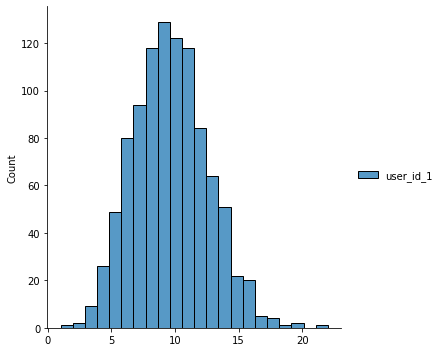

In [9]:
sns.displot(data=df_matches_group_0)

In [10]:
scipy.stats.normaltest(df_matches_group_0.user_id_1)

NormaltestResult(statistic=13.206395346448232, pvalue=0.0013560249726511423)

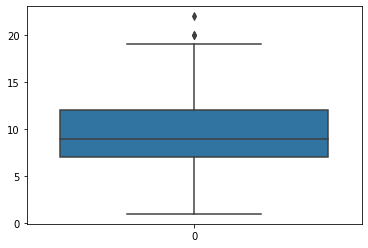

In [11]:
sns.boxplot(data=df_matches_group_0.user_id_1)

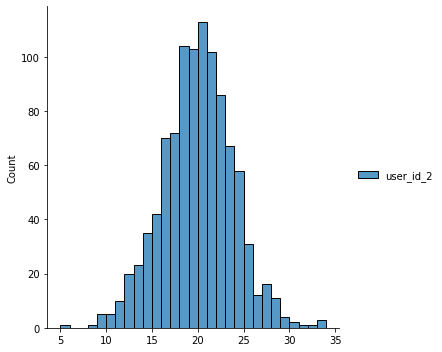

In [12]:
sns.displot(data=df_matches_group_1)

In [13]:
scipy.stats.normaltest(df_matches_group_1.user_id_2)

NormaltestResult(statistic=8.13369061794194, pvalue=0.017131347458968414)

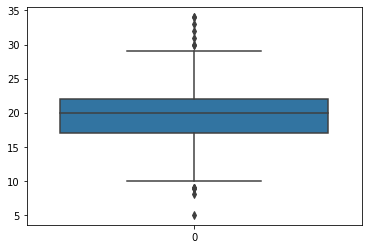

In [14]:
sns.boxplot(data=df_matches_group_1.user_id_2)

Распределения в обоих группах очень похожи на нормальное, но при этом не проходят тест на нормальность. Вероятнее всего, из-за того, что на крайних левых и правых значениях мэтчей есть выбросы, что видно на боксплотах. Тем не менее, пока я буду считать, что данное распределение близко к нормальному и хочу ля сравнения групп использовать т-тест. Также проверю группы на гомоскедастичность дисперсий тестом Левина.

In [15]:
scipy.stats.levene(df_matches_group_0.user_id_1, df_matches_group_1.user_id_2)

LeveneResult(statistic=33.4398645162909, pvalue=8.510490228224667e-09)

Тест на гомоскедастичность пройден, поэтому попробую провести т-тест.

In [16]:
scipy.stats.ttest_ind(df_matches_group_0.user_id_1, df_matches_group_1.user_id_2)

Ttest_indResult(statistic=-63.41870685385005, pvalue=0.0)

In [17]:
df_matches_group_0.user_id_1.mean()

9.564870259481038

In [18]:
df_matches_group_0.user_id_1.median()

9.0

In [19]:
df_matches_group_1.user_id_2.mean()

19.482965931863728

In [20]:
df_matches_group_1.user_id_2.median()

20.0

Т-тест показывает довольно значимые различия между группами, и по абсолютным значениям средних и медиан вижу, что в среднем число мэтчей на человека так же, как и конверсия в мэтч увеличилось примерно в 2 раза и эти различия статзначимы в соответствии с проведенным т-тестом. Но так как есть основания полагать, что из-за непрохождения теста на нормальность т-тест нельзя было использовать, я проведу ещё тест бутстрап для понимания адекватности результатов т-теста.

In [21]:
scipy.stats.bootstrap((df_matches_group_0.user_id_1, ), np.median, method='basic')

BootstrapResult(confidence_interval=ConfidenceInterval(low=8.0, high=9.0), standard_error=0.4634313933059751)

In [22]:
scipy.stats.bootstrap((df_matches_group_1.user_id_2, ), np.median, method='basic')

BootstrapResult(confidence_interval=ConfidenceInterval(low=20.0, high=21.0), standard_error=0.4532884699853922)

Тест Бутстрап также показывает статзначимые различия, так как доверительные интервалы медиан не пересекаются.

**Ответ:** новый алгоритм стоит включать для всех пользователей, так как тестовая группа показала статзначимый прирост метрик конверсии в мэтч и среднего количество мэтчей на человека примерно в 2 раза.